# Nixtla MLForecast Model


# Table Of Contents
[1. Introduction](#1.Introduction)\
[2. Features](#2.Features)
- **- Basic Steps To Use MLForecast**
- **- Case Study with M5 Forecasting - Accuracy**\
[3. About some important techniques](#3.-About_some_important_techniques)\
[4. Setup Data](#4.-Setup_Data)\
[5. Fit Model](#5.-Fit_Model)\
[6. Model Forecasting](#6.-Model_Forecasting)\
[7. Final Thought](#7.-Final_Thought)

# Introduction
Mlforecast is a platform designed for conducting time series predictions through the utilization of machine learning algorithms, offering the capability to expand operations to handle extensive datasets by leveraging remote clusters.

MLForecast offers several key features that make it a powerful tool for machine learning in production environments. Firstly, it provides efficient feature engineering capabilities, allowing users to effectively train any machine learning model. This includes popular models such as those found in the sklearn library. Additionally, MLForecast is designed to handle large datasets, making it suitable for fitting millions of time series. With its ability to scale well and deliver accurate results, MLForecast is a reliable choice for forecasting in real-world scenarios.


### Features:
Swift feature engineering solutions for time series prediction in Python.
Seamless integration with pandas, polars, spark, dask, and ray.
Incorporation of Probabilistic Forecasting using Conformal Prediction.
Capability to handle exogenous variables and static covariates.
Easy-to-use sklearn syntax: .fit and .predict.

### Installation
%pip install -qqq mlforecast

### Step 1:
Organize the time series data in the pandas dataframe using the long format, where each row corresponds to an observation for a particular series and timestamp.

In [1]:
from mlforecast.utils import generate_daily_series

series = generate_daily_series(
    n_series=20,
    max_length=100,
    n_static_features=1,
    static_as_categorical=False,
    with_trend=True
)
series.head()


,unique_id,ds,y,static_0
0,id_00,2000-01-01,17.519167,72
1,id_00,2000-01-02,87.799695,72
2,id_00,2000-01-03,177.442975,72
3,id_00,2000-01-04,232.704110,72
4,id_00,2000-01-05,317.510474,72


### Step 2: Models
Subsequently, establish the models. These may consist of any regressor that adheres to the scikit-learn API.

In [5]:
import lightgbm as lgb
from sklearn.linear_model import LinearRegression



In [6]:
models = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
]


### Step 3: Forecast Object
Create a new MLForecast object by specifying the desired models and features. These features include:
- lags,
- transformations on the lags, and
- date features.

- Additionally, we have the option to define transformations for the target variable before fitting, which will then be applied during prediction.

In [7]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences





### Step 4: Training
To train the models and calculate the features, execute the fit function on our Forecast object.

In [19]:
fcst = MLForecast(
    models=models,
    freq='D',
    lags=[7, 14],
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=28)]
    },
    date_features=['dayofweek'],
    target_transforms=[Differences([1])],
)



### Step 5: Fit the Model

In [20]:
fcst.fit(series)


MLForecast(models=[LGBMRegressor, LinearRegression], freq=D, lag_features=['lag7', 'lag14', 'expanding_mean_lag1', 'rolling_mean_lag7_window_size28'], date_features=['dayofweek'], num_threads=1)

### Step 6: Predict the Model

In [21]:
predictions = fcst.predict(14)
predictions


,unique_id,ds,LGBMRegressor,LinearRegression
0,id_00,2000-04-04,299.923771,311.432371
1,id_00,2000-04-05,365.424147,379.466214
2,id_00,2000-04-06,432.562441,460.234028
3,id_00,2000-04-07,495.628000,524.278924
4,id_00,2000-04-08,60.786223,79.828767
...,...,...,...,...
275,id_19,2000-03-23,36.266780,28.333215
276,id_19,2000-03-24,44.370984,33.368228
277,id_19,2000-03-25,50.746222,38.613001
278,id_19,2000-03-26,58.906524,43.447398


### Step 7: Visualization

In [22]:
from utilsforecast.plotting import plot_series


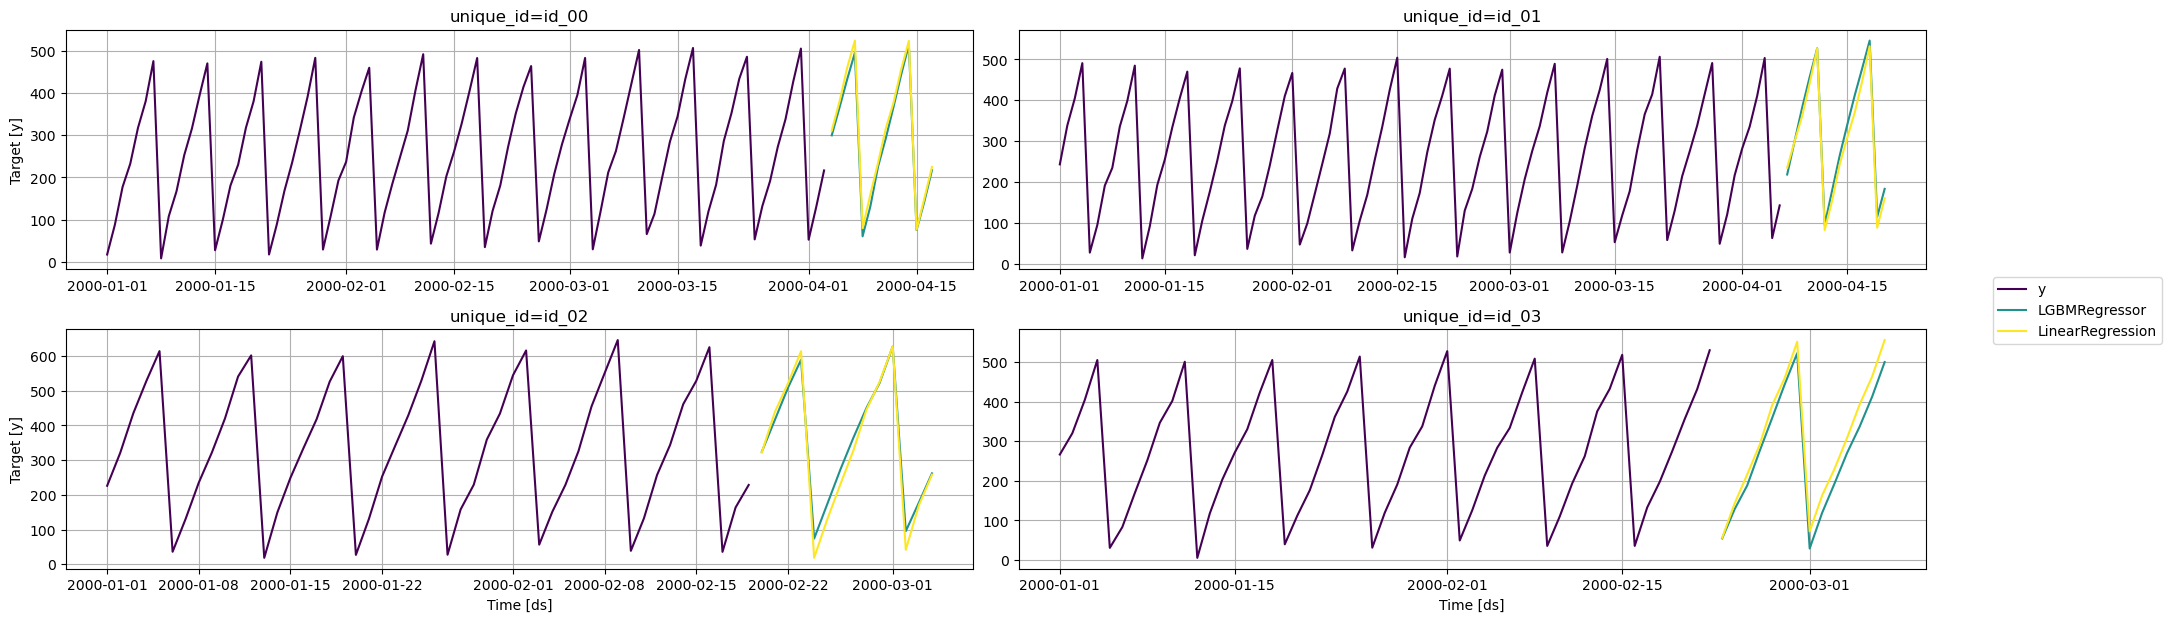

In [25]:
fig = plot_series(series, predictions, max_ids=4, plot_random=False)
fig


### Case Study with M5 Forecasting - Accuracy
Walmart, the global leader in terms of revenue, provides sales data that can be utilized to predict the daily sales for the upcoming 28 days. This comprehensive dataset encompasses information on item level, department, product categories, and store details for stores located in three US States namely California, Texas, and Wisconsin. Moreover, it also includes explanatory variables like price, promotions, day of the week, and special events. By leveraging this extensive dataset, the accuracy of forecasting can be significantly enhanced, enabling precise point forecasts for the unit sales of diverse products sold by Walmart in the United States.

### About some important techniques:
- LightGBM: This is primarily used for building gradient-boosting decision trees. Gradient boosting is an ensemble learning technique that sequentially builds weak learners (decision trees in this case) to minimize the overall model error by gradient descent.
- ExpandingMean: Represent a class or function that computes an expanding mean over a time series. Expanding mean is a transformation where each element in the output is the mean of all previous elements up to that point.
- RollingMean: RollingMean signifies a class or function that computes a rolling mean over a time series. Rolling mean (or Moving Average) smooths a time series by averaging values within a specified window size.
- SeasonalRollingMean is a statistical technique used to smooth time series data by calculating rolling means over seasonal periods.
- pivot_table: This Pandas method reshapes `preds`, which is assumed to be a DataFrame containing predictions, into a pivot table format.

In [2]:
# Library import
from pathlib import Path

import lightgbm as lgb
import mlforecast
import numpy as np
import pandas as pd
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, SeasonalRollingMean

# Version
mlforecast.__version__

'0.13.0'

### Setup Data### Calender Data


In [3]:
cal_dtypes = {
    'd': 'category',
    'wm_yr_wk': np.uint16,
    'event_name_1': 'category',
    'event_type_1': 'category',
    'event_name_2': 'category',
    'event_type_2': 'category',
    'snap_CA': np.uint8,
    'snap_TX': np.uint8,
    'snap_WI': np.uint8,
}
cal = pd.read_csv('calendar.csv', 
                  dtype=cal_dtypes, 
                  usecols=list(cal_dtypes.keys()) + ['date'], 
                  parse_dates=['date'])
event_cols = [k for k in cal_dtypes if k.startswith('event')]
for col in event_cols:
    cal[col] = cal[col].cat.add_categories('nan').fillna('nan')

In [4]:
cal.head(3)

,date,wm_yr_wk,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,d_1,nan,nan,nan,nan,0,0,0
1,2011-01-30,11101,d_2,nan,nan,nan,nan,0,0,0
2,2011-01-31,11101,d_3,nan,nan,nan,nan,0,0,0


### Prices Data

In [5]:
prices_dtypes = {
    'store_id': 'category',
    'item_id': 'category',
    'wm_yr_wk': np.uint16,
    'sell_price': np.float32
}
prices = pd.read_csv('sell_prices.csv', dtype=prices_dtypes)

In [6]:
prices.head(3)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


### Sales

In [7]:
sales_dtypes = {
    'id': 'category',
    'item_id': prices.item_id.dtype,
    'dept_id': 'category',
    'cat_id': 'category',
    'store_id': 'category',
    'state_id': 'category',
    **{f'd_{i}': np.float32 for i in range(1942)}
}
sales = pd.read_csv(
 'sales_train_evaluation.csv',
    dtype=sales_dtypes,
)

In [8]:
sales.head(3)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0


In [9]:
long = sales.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='d',
    value_name='y'
)

In [10]:
%%time
print(long.shape[0])
long['d'] = long['d'].astype(cal.d.dtype)
long = long.merge(cal, on=['d'])
dates = sorted(long['date'].unique())
long = long.sort_values(['id', 'date'])
without_leading_zeros = long['y'].gt(0).groupby(long['id'], observed=True).transform('cummax')
above_min_date = long['date'] >= dates[-400]
keep_mask = without_leading_zeros & above_min_date
long = long[keep_mask]
print(long.shape[0])

59181090
12159132
CPU times: total: 33.2 s
Wall time: 50.6 s


- The line `above_min_date = long['date'] >= dates[-400]`: filters the DataFrame or Series `long` based on the condition that the dates in the `'date'` column are greater than or equal to the date located at the 400th position from the end of the `dates` list.
- The term "Wall time" refers to the actual elapsed time taken to complete a process or task, as measured by a wall clock or a stopwatch.
 to your specific date range requirements.

In [11]:
long = long.merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'])
last_wmyrwk = long['wm_yr_wk'].max()
last_date_train = long['date'].max()
long = long.drop(columns=['d', 'wm_yr_wk'])
long = long.sample(frac=1.0, random_state=0)

# build X_df
future_cal = cal[cal['date'] > last_date_train]
future_prices = prices[prices['wm_yr_wk'] >= last_wmyrwk].copy()
future_prices['id'] = future_prices['item_id'].astype(str) + '_' + future_prices['store_id'].astype(str) + '_evaluation'
X_df = future_prices.merge(future_cal, on='wm_yr_wk').drop(columns=['store_id', 'item_id', 'wm_yr_wk', 'd'])

In [15]:
model_params = {
    'verbose': -1,                  # This parameter controls the verbosity of the model's output during training.
    'num_threads': 4,               # Specifies the number of threads to use for parallelized execution.
    'force_col_wise': True,         # This parameter is specific to LightGBM and determines whether to use a column-wise (True) or row-wise (False).
    'num_leaves': 256,
    'n_estimators': 50,
}

fcst = MLForecast(
    models=[lgb.LGBMRegressor(**model_params)],
    freq='D',
    lags=[7 * (i+1) for i in range(8)],
    lag_transforms = {
        1:  [ExpandingMean()],
        7:  [RollingMean(7), RollingMean(14), RollingMean(28), SeasonalRollingMean(7, 4)],
        14: [RollingMean(7), RollingMean(14), RollingMean(28), SeasonalRollingMean(7, 4)],
        28: [RollingMean(7), RollingMean(14), RollingMean(28), SeasonalRollingMean(7, 4)],
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],    
    num_threads=4,
)

### Fit the Model

In [13]:
%%time
fcst.fit(
    long,
    id_col='id',
    time_col='date',
    target_col='y',
    static_features=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
)

CPU times: total: 3min 53s
Wall time: 1min 32s


MLForecast(models=[LGBMRegressor], freq=D, lag_features=['lag7', 'lag14', 'lag21', 'lag28', 'lag35', 'lag42', 'lag49', 'lag56', 'expanding_mean_lag1', 'rolling_mean_lag7_window_size7', 'rolling_mean_lag7_window_size14', 'rolling_mean_lag7_window_size28', 'seasonal_rolling_mean_lag7_season_length7_window_size4', 'rolling_mean_lag14_window_size7', 'rolling_mean_lag14_window_size14', 'rolling_mean_lag14_window_size28', 'seasonal_rolling_mean_lag14_season_length7_window_size4', 'rolling_mean_lag28_window_size7', 'rolling_mean_lag28_window_size14', 'rolling_mean_lag28_window_size28', 'seasonal_rolling_mean_lag28_season_length7_window_size4'], date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'], num_threads=4)

### Predict the Model

In [14]:
%time 
preds = fcst.predict(28, X_df=X_df)

CPU times: total: 0 ns
Wall time: 0 ns


In [16]:
MLForecast_Final = preds.pivot_table(index='id', columns='date', observed=True)
MLForecast_Final.columns = [f'F{i+1}' for i in range(28)]
MLForecast_Final.columns.name = None
MLForecast_Final.index.name = 'id'
#MLForecast_Final

In [17]:
MLForecast_Final.head(3)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_evaluation,0.851461,0.832224,0.796482,0.954522,1.020796,1.380087,1.300216,0.886998,0.923657,0.945963,...,0.958056,1.346782,1.271043,0.840132,0.799373,0.801135,0.926332,0.941998,1.166318,1.096699
HOBBIES_1_002_CA_1_evaluation,0.307082,0.320370,0.297425,0.293146,0.344540,0.400814,0.391188,0.291923,0.285291,0.292966,...,0.341222,0.410181,0.462158,0.338453,0.332249,0.335902,0.331950,0.363919,0.424782,0.385183
HOBBIES_1_003_CA_1_evaluation,0.551267,0.529019,0.527277,0.599512,0.767732,0.800839,0.832197,0.585946,0.579314,0.601344,...,0.705381,0.782182,0.875032,0.571769,0.580318,0.567327,0.607562,0.707429,0.763306,0.774720


- The id in each row is a combination of an item_id and a store_id, representing either validation or evaluation.
- The prediction includes 28 forecast days (F1 to F28) of items sold for each row.
- In the case of validation rows, this corresponds to days d_1914 - d_1941,
- while for evaluation rows, it corresponds to days d_1942 - d_1969.

# Final Thoughts
The advancement of the theory and practice of forecasting will persist in the work. The techniques employed have the potential to be implemented across diverse business sectors, including the establishment of suitable inventory or service levels. Using its business assistance and training, the MLForecasting technique will facilitate the dissemination of tools and knowledge, enabling others to attain more precise and well-adjusted forecasts, minimize wastage, and comprehend the significance of uncertainty and its associated risks.